In [1]:
#install yfinance and potentially update TensorFlow.
!pip install yfinance
!pip install joblib

In [2]:
#data collection
import yfinance as yf

# Download Tesla stock price data
ticker = 'TSLA'
data = yf.download(ticker, start='2010-01-01', end='2023-12-31')
data.to_csv('tesla_stock_data.csv')  # Save to CSV

# Display first few rows
data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [3]:
#data preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load the dataset
data = pd.read_csv('tesla_stock_data.csv', index_col='Date', parse_dates=True)

# Define RSI function
def compute_RSI(data, time_window):
    diff = data.diff(1).dropna()
    up_chg = 0 * diff
    down_chg = 0 * diff
    up_chg[diff > 0] = diff[diff > 0]
    down_chg[diff < 0] = -diff[diff < 0]
    up_chg_avg = up_chg.rolling(window=time_window, min_periods=1).mean()
    down_chg_avg = down_chg.rolling(window=time_window, min_periods=1).mean()
    rs = up_chg_avg / down_chg_avg
    rsi = 100 - 100 / (1 + rs)
    return rsi

# Feature engineering
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()
data['RSI'] = compute_RSI(data['Close'], 14)

# Drop rows with missing values
data = data.dropna()

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Save the scaler for future use
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

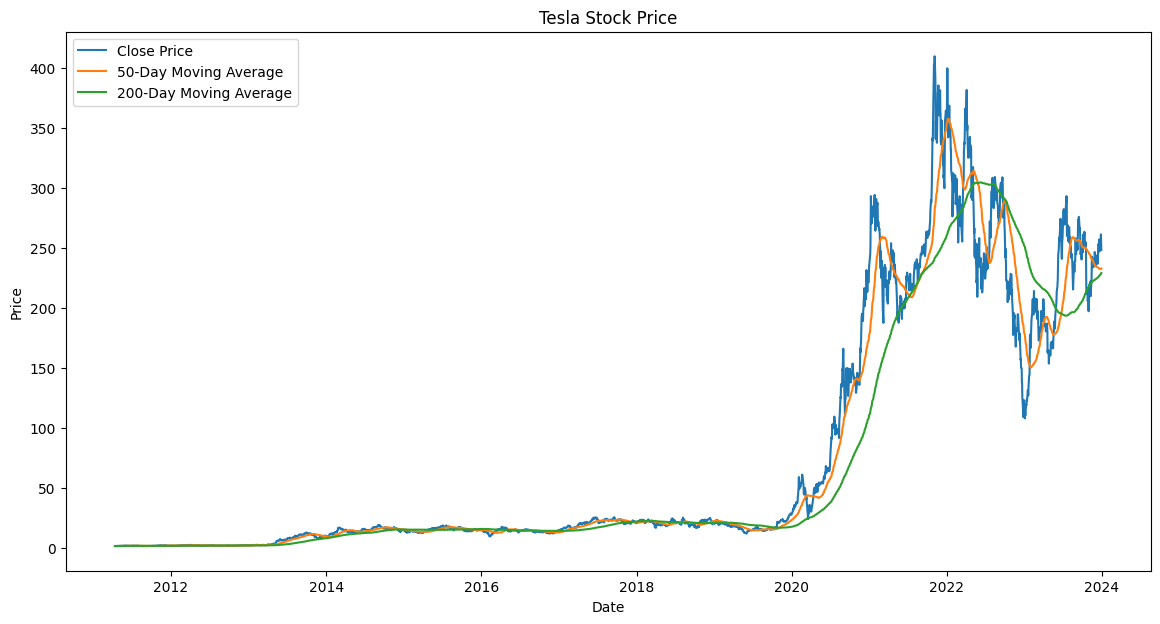

In [4]:
#Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt

# Plot closing price and moving averages
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['MA50'], label='50-Day Moving Average')
plt.plot(data['MA200'], label='200-Day Moving Average')
plt.title('Tesla Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [7]:
# Model Training
# Normalize only the 'Close' column
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data[['Close']])

# Save the scaler for future use
joblib.dump(scaler, 'scaler.pkl')

# Prepare data for LSTM model
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step)]
        X.append(a)
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)

time_step = 100
close_data = data['Close'].values.reshape(-1, 1)
X, y = create_dataset(close_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=100)

# Save the model
model.save('tesla_stock_lstm_model.h5')



Epoch 1/100
39/39 [==============================] - 11s 101ms/step - loss: 0.0027
Epoch 2/100
39/39 [==============================] - 5s 125ms/step - loss: 2.7532e-04
Epoch 3/100
39/39 [==============================] - 5s 115ms/step - loss: 2.0979e-04
Epoch 4/100
39/39 [==============================] - 4s 101ms/step - loss: 2.1920e-04
Epoch 5/100
39/39 [==============================] - 5s 122ms/step - loss: 1.8923e-04
Epoch 6/100
39/39 [==============================] - 5s 117ms/step - loss: 1.9788e-04
Epoch 7/100
39/39 [==============================] - 4s 100ms/step - loss: 1.5633e-04
Epoch 8/100
39/39 [==============================] - 4s 113ms/step - loss: 1.6114e-04
Epoch 9/100
39/39 [==============================] - 5s 128ms/step - loss: 1.5746e-04
Epoch 10/100
39/39 [==============================] - 4s 101ms/step - loss: 1.9399e-04
Epoch 11/100
39/39 [==============================] - 4s 105ms/step - loss: 1.3080e-04
Epoch 12/100
39/39 [==============================] - 6

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 1s 23ms/step
RMSE: 12.011133217809727


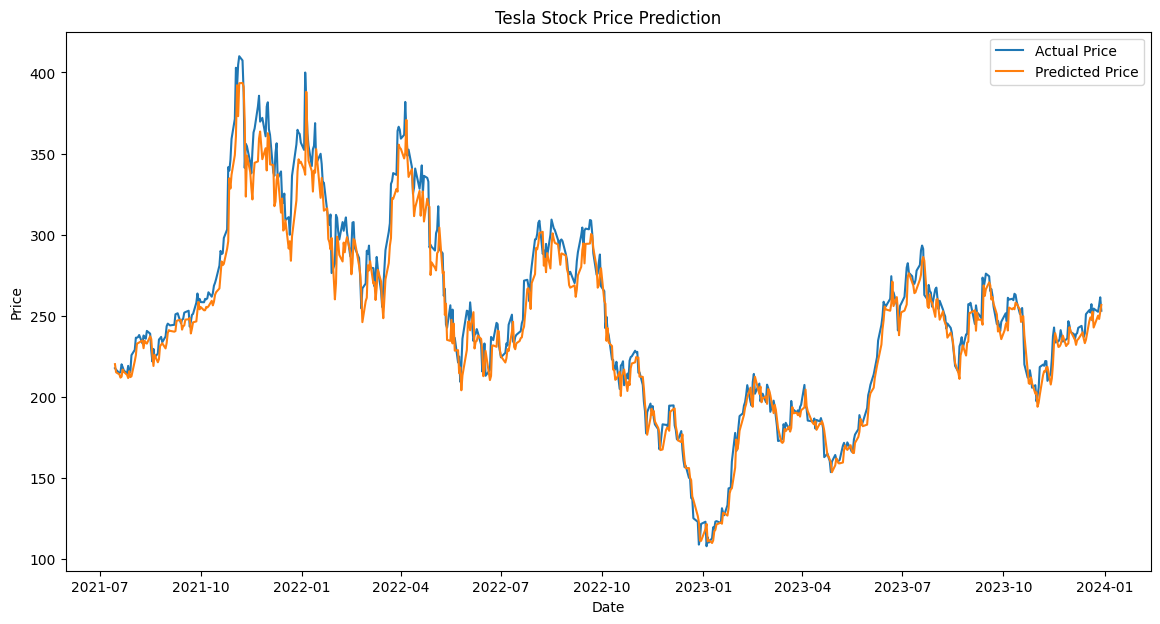

In [8]:
#Model Evaluation
# Load the model and scaler
model = tf.keras.models.load_model('tesla_stock_lstm_model.h5')
scaler = joblib.load('scaler.pkl')

# Predict on test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Inverse transform the y_test data
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data.index[train_size+time_step+1:], y_test, label='Actual Price')
plt.plot(data.index[train_size+time_step+1:], predictions, label='Predicted Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
